<a href="https://colab.research.google.com/github/Jeremy185/grupo3_TCE_2024/blob/main/Proyecto_TCE/Jupiter/proyecto_comu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modulo de transmisor



En este apartado se resume el desarrollo del transmisor, el cual tiene la capacidad de capturar la informacion de latidos por minuto (bpm) que provienen de un monitor de ritmo cardiaco, los datos son tomados mediante un protocolo de comunicacion UART.

## Bloque Latidos por minuto/Prueba Ecostress


Este bloque tiene como objetivo modelar la adquisicion de datos entre el monitor cardiaco y el transmisor (TX)

In [ ]:
import pandas as pd
from scipy.stats import anderson

# Leer el archivo Excel
df = pd.read_excel('/content/Dataset.xlsx')
df1 = pd.read_excel('/content/Dataset_Crudo.xlsx')

# Extraer la columna relevante
data = df['BPM']
data2 = df1['BPM']

# Realizar la prueba de Anderson-Darling
result = anderson(data)

# Imprimir los resultados
print('p-value:', result[1])
print('Standard deviation:', data.std())
print('Average:', data.mean())

p-value: [0.559 0.637 0.764 0.891 1.06 ]
Standard deviation: 19.72707993812042
Average: 129.15458577437957


Los valores p obtenidos de la prueba de Anderson-Darling son mayores que 0.05 (niveles típicos de significancia). Esto sugiere que no hay suficiente evidencia para rechazar la hipótesis nula de que los datos de latidos por minuto (bpm) siguen una distribución normal. Ademas, se tiene un promedio de 129.15 bpm y una desviación estándar de 19.73 bpm.

A continuación, se crea un histograma con los datos analizados.

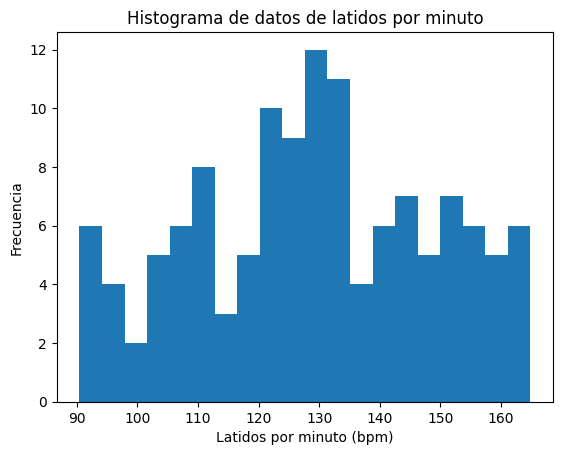

In [ ]:
# prompt: haz un histograma de los datos de excel
import matplotlib.pyplot as plt

plt.hist(data, bins=20)
plt.xlabel('Latidos por minuto (bpm)')
plt.ylabel('Frecuencia')
plt.title('Histograma de datos de latidos por minuto')
plt.show()


En el histograma anterior se puede apreciar que los datos muestran una distribucion de asimetría negativa.

Ahora, se crea una grafica de caja con el fin de identificar valores atipicos, ademas tambien se implementara el test de Grubbs.

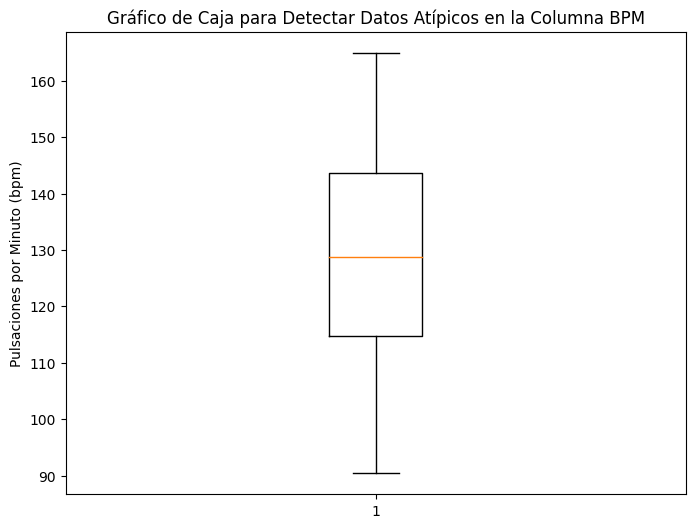

Valores atípicos identificados con el test de Grubbs:
[]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import zscore
from scipy.stats import t
import numpy as np

# Especifica la ruta al archivo de Excel en tu Google Drive
ruta_archivo_excel = '/content/Dataset.xlsx'

# Lee el archivo de Excel en un DataFrame de Pandas
datos = pd.read_excel(ruta_archivo_excel, usecols=['BPM'])

# Genera el gráfico de caja (box plot)
plt.figure(figsize=(8, 6))
plt.boxplot(datos['BPM'])
plt.title('Gráfico de Caja para Detectar Datos Atípicos en la Columna BPM')
plt.ylabel('Pulsaciones por Minuto (bpm)')
plt.show()



def test_grubbs(data, alpha=0.05):
    """
    Test de Grubbs para identificar valores atípicos en un conjunto de datos univariado.

    Parámetros:
    data (array): Array de numpy que contiene los datos.
    alpha (float): Nivel de significancia para el test (valor por defecto es 0.05).

    Retorna:
    array: Array que contiene los valores atípicos identificados por el test de Grubbs.
    """
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    data_abs = np.abs(data - mean)
    max_index = np.argmax(data_abs)
    max_deviation = data_abs[max_index]
    critical_value = (n - 1) / np.sqrt(n) * np.sqrt(t.ppf(1 - alpha / (2 * n), n - 2) ** 2 / (n - 2 + t.ppf(1 - alpha / (2 * n), n - 2) ** 2))

    if max_deviation > critical_value * std_dev:
        return np.array([data[max_index]])
    else:
        return np.array([])

# Usar el test de Grubbs para identificar valores atípicos en la columna 'bpm'
valores_atipicos_grubbs = test_grubbs(datos['BPM'])

# Imprimir los valores atípicos identificados
print("Valores atípicos identificados con el test de Grubbs:")
print(valores_atipicos_grubbs)

Con respecto a los resultados anteriores se puede concluir que ningun valor atipico fue encontrado.


## Bloque procesamieto

En este apartado se procede a determinar el mejor tipo de filtrado para los datos que se estan manejando y para la aplicacion, cabe destacar, que el resultado debe ser el mas preciso posible, ya que, es una aplicación medica. Se tomaron en consideracion dos tipos de filtrados, se muestran a continuacion en la matriz trade-off.


| Criterio Técnico              | Media Móvil Simple (SMA) | Filtro de Kalman |
|-------------------------------|--------------------------|------------------|
| Facilidad de Implementación   | Alta                  | Baja          |
| Efectividad en la Filtración | Media                 | Alta          |
| Requerimientos de Recursos    | Bajos                 | Altos         |
| Adaptabilidad a Cambios       | Baja                  | Alta          |
| Complejidad de Entendimiento  | Baja                  | Alta          |




Se escogio el filtro SMA como posible solucion, a continuación, crea la implementacion y se compara con los datos sin filtrar para visualizar su efectividad y cual tipo de filtro funciona mejor.

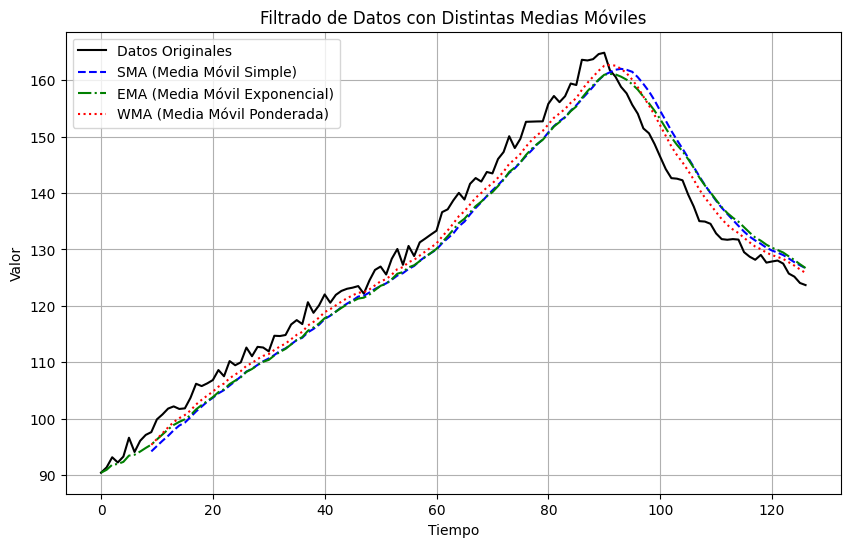

Tiempo promedio de filtrado para SMA: 0.0004186367988586426 segundos
Tiempo promedio de filtrado para EMA: 0.00020965576171875 segundos
Tiempo promedio de filtrado para WMA: 0.0006787550449371338 segundos


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Leer el archivo de Excel
ruta_archivo_excel = '/content/Dataset.xlsx'
datos = pd.read_excel(ruta_archivo_excel)

# Seleccionar la columna de interés
columna = 'BPM'
serie_temporal = datos[columna]

# Calcular las medias móviles
sma = serie_temporal.rolling(window=10).mean()  # SMA (Media Móvil Simple)
ema = serie_temporal.ewm(span=10).mean()        # EMA (Media Móvil Exponencial)
weights = np.arange(1, 11) / np.sum(np.arange(1, 11))
wma = serie_temporal.rolling(window=10).apply(lambda x: np.dot(x, weights), raw=True) # WMA (Media Móvil Ponderada)

# Graficar los datos originales y las medias móviles
plt.figure(figsize=(10, 6))
plt.plot(serie_temporal, label='Datos Originales', color='black')
plt.plot(sma, label='SMA (Media Móvil Simple)', linestyle='--', color='blue')
plt.plot(ema, label='EMA (Media Móvil Exponencial)', linestyle='-.', color='green')
plt.plot(wma, label='WMA (Media Móvil Ponderada)', linestyle=':', color='red')
plt.title('Filtrado de Datos con Distintas Medias Móviles')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

#-------------------Tiempo de ejecucion de los filtros---------------------------------------------

def filter_signal(data, filter_type='sma', window_size=10, repetitions=200):
    """
    Función para filtrar una señal utilizando diferentes tipos de medias móviles y calcular el tiempo promedio.

    Parámetros:
    - data: Serie temporal de datos.
    - filter_type: Tipo de filtro a utilizar ('sma' para Media Móvil Simple, 'ema' para Media Móvil Exponencial, 'wma' para Media Móvil Ponderada). Por defecto, 'sma'.
    - window_size: Tamaño de la ventana para el filtro (solo aplica para SMA y WMA). Por defecto, 10.
    - repetitions: Número de repeticiones para calcular el tiempo promedio. Por defecto, 200.

    Retorna:
    - elapsed_time_avg: Tiempo promedio transcurrido durante el filtrado en segundos.
    """
    total_time = 0

    for _ in range(repetitions):
        start_time = time.time()

        if filter_type == 'sma':
            filtered_data = data.rolling(window=window_size).mean()
        elif filter_type == 'ema':
            filtered_data = data.ewm(span=window_size).mean()
        elif filter_type == 'wma':
            weights = np.arange(1, window_size + 1) / np.sum(np.arange(1, window_size + 1))
            filtered_data = data.rolling(window=window_size).apply(lambda x: np.dot(x, weights), raw=True)
        else:
            raise ValueError("Tipo de filtro no válido. Use 'sma', 'ema' o 'wma'.")

        elapsed_time = time.time() - start_time
        total_time += elapsed_time

    elapsed_time_avg = total_time / repetitions

    return elapsed_time_avg


# Calcular el tiempo promedio de filtrado para Media Móvil Simple (SMA)
sma_avg_time = filter_signal(datos, filter_type='sma')
print("Tiempo promedio de filtrado para SMA:", sma_avg_time, "segundos")

# Calcular el tiempo promedio de filtrado para Media Móvil Exponencial (EMA)
ema_avg_time = filter_signal(datos, filter_type='ema')
print("Tiempo promedio de filtrado para EMA:", ema_avg_time, "segundos")

# Calcular el tiempo promedio de filtrado para Media Móvil Ponderada (WMA)
wma_avg_time = filter_signal(datos, filter_type='wma')
print("Tiempo promedio de filtrado para WMA:", wma_avg_time, "segundos")




En los resultados del codigo anterior se puede apreciar como el metodo de WMA presenta una grafica mas cercana a la grafica original y los valores se ven bastantes suavizados, ademas el tiempo promedio de ejecucion del script que filtra los datos es de 661.88 micro segundos aproximandamente.

Para poder pasar el filtro seleccionado al SoC nRF52832 es necesario seguir un proceso metodologico que se explica a continuacion.

### Estrategia:

1. **Comprender el Código Python:**
   - Analizar y comprender completamente el filtro implementado en Python, incluyendo el algoritmo utilizado, las estructuras de datos involucradas y cualquier biblioteca externa utilizada.

2. **Revisar y Adaptar las Bibliotecas:**
   - Identificar las bibliotecas de Python utilizadas en el filtro y buscar alternativas en C++ que proporcionen funcionalidades similares.

3. **Transcribir el Código a C++:**
   - Transcribir el algoritmo del filtro a código C++. Asegurarse de mantener la lógica y la estructura del algoritmo, tener en cuenta las diferencias entre Python y C++, como la sintaxis, el manejo de tipos de datos y las funciones de biblioteca disponibles.

4. **Optimizar el Código:**
   - Optimizar el código C++ para el rendimiento y la eficiencia de memoria. .

5. **Pruebas y Depuración:**
   - Realizar pruebas exhaustivas en el código C++ para asegurarte de que funcione correctamente y produzca resultados similares a los del código Python original. Esto puede incluir pruebas unitarias, pruebas de integración y pruebas en el hardware objetivo (SoC nRF52832).

6. **Integración con el Proyecto del SoC nRF52832:**
   - Integrar el código del filtro C++ en el proyecto del SoC nRF52832, utilizando el SDK (Software Development Kit) y las herramientas de desarrollo proporcionadas por Nordic Semiconductor.

El SDK (software developtment kit) proporcionado por Nordic semiconductor provee un ambiente de desarrollo con ejemplos, bibliotecas, protocoloes, compilers y todo lo necesario para poder adaptar el codigo python al microcontrolador objetivo.

### DSPs en el SoC 2RF52832: Arquitectura y Ventaja como Coprocesador

#### Arquitectura de los DSPs:

Los DSPs (Procesadores de Señal Digital) pueden tener diferentes arquitecturas dependiendo del fabricante y del modelo específico. Sin embargo, la mayoría de los DSPs comparten algunas características comunes en su arquitectura:

1. **Pipeline Profundo:** Los DSPs suelen tener un pipeline profundo que permite la ejecución de múltiples instrucciones de manera simultánea y en paralelo.

2. **Unidades de Procesamiento Especializadas:** Están diseñados para realizar operaciones matemáticas y de procesamiento de señales de manera eficiente, con unidades de procesamiento especializadas.

3. **Memoria Especializada:** Integran memoria y periféricos específicos para el procesamiento de señales, como RAM y ROM optimizadas para estas operaciones.

4. **Instrucciones SIMD:** Muchos DSPs soportan instrucciones SIMD que permiten realizar operaciones en paralelo en múltiples datos simultáneamente.

#### Ventajas de usar DSPs como Coprocesador:

1. **Eficiencia en Procesamiento de Señales:** Están diseñados específicamente para aplicaciones de procesamiento de señales, lo que los hace altamente eficientes en este tipo de tareas.

2. **Rendimiento Optimizado:** La arquitectura especializada y el conjunto de instrucciones optimizado permiten un rendimiento superior en aplicaciones de procesamiento de señales.

3. **Bajo Consumo de Energía:** Están optimizados para operaciones con bajo consumo de energía.

4. **Programabilidad y Flexibilidad:** Aunque están diseñados para aplicaciones específicas, son programables y pueden adaptarse a una amplia gama de algoritmos y aplicaciones de procesamiento de señales.

5. **Integración con otros Componentes del Sistema:** Se integran fácilmente con otros componentes del sistema, permitiendo diseñar sistemas complejos y eficientes.

En resumen, los DSPs ofrecen una combinación única de rendimiento, eficiencia energética y flexibilidad que los hace ideales como coprocesadores para acelerar aplicaciones de procesamiento de señales en una variedad de dispositivos y sistemas.

## Bloque codificación

In [ ]:
import pandas as pd
import time

# Leer el archivo Excel
df = pd.read_excel('/content/Dataset.xlsx')

# Extraer la columna relevante
data = wma

# Codificación Hamming (7,4)
def hamming_encode_7_4(data):
    # Inicializar lista para almacenar los bits codificados
    encoded_data = []

    # Calcular bits de paridad
    p1 = (data[0] + data[1] + data[3]) % 2
    p2 = (data[0] + data[2] + data[3]) % 2
    p3 = (data[1] + data[2] + data[3]) % 2

    # Insertar bits de paridad y datos en la lista de datos codificados
    encoded_data.extend([p1, p2, data[0], p3, data[1], data[2], data[3]])

    return encoded_data
#Codificación Hamming (15,11)

def hamming_encode_15_11(data):
    # Inicializar lista para almacenar los bits codificados
    encoded_data = []

    # Calculando los bits de paridad (p1-p4)
    p1 = (data[0] + data[1] + data[3] + data[4] + data[6] + data[8] + data[10]) % 2
    p2 = (data[0] + data[2] + data[3] + data[5] + data[6] + data[9] + data[10]) % 2
    p3 = (data[1] + data[2] + data[3] + data[7] + data[8] + data[9] + data[10]) % 2
    p4 = (data[4] + data[5] + data[6] + data[7] + data[8] + data[9] + data[10]) % 2

    # Insertar bits de paridad y datos en la lista de datos codificados
    encoded_data.extend([p1, p2, data[0], p3, data[1], data[2], data[3], p4, data[4], data[5], data[6], data[7], data[8], data[9], data[10]])

    return encoded_data

def measure_hamming_encoding_time(data, encoding_function, repetitions=200):
    total_time = 0

    for _ in range(repetitions):
        start_time = time.time()

        # Aplicar la codificación de Hamming
        encoded_data = [encoding_function([int(bit) for bit in bin(int(dato) if not np.isnan(dato) else 0)[2:].zfill(4 if encoding_function == hamming_encode_7_4 else 11)]) for dato in data]
        elapsed_time = time.time() - start_time
        total_time += elapsed_time

    elapsed_time_avg = total_time / repetitions

    return elapsed_time_avg

# Medir el tiempo de codificación para Hamming (7,4)
hamming_avg_time_7_4 = measure_hamming_encoding_time(data, hamming_encode_7_4)
print("Tiempo promedio de codificación de Hamming (7,4):", hamming_avg_time_7_4, "segundos")

# Medir el tiempo de codificación para Hamming (15,11)
hamming_avg_time_15_11 = measure_hamming_encoding_time(data, hamming_encode_15_11)
print("Tiempo promedio de codificación de Hamming (15,11):", hamming_avg_time_15_11, "segundos")

# Codificar los datos BPM usando el código de Hamming (7,4)
datos_codificados_7_4 = [hamming_encode_7_4([int(bit) for bit in bin(int(dato) if not np.isnan(dato) else 0)[2:].zfill(4)]) for dato in data]

# Crear un DataFrame con los datos originales de BPM y los datos codificados
df_resultado_7_4 = pd.DataFrame({'BPM': data, 'BPM Codificado': datos_codificados_7_4})

# Codificar los datos BPM usando el código de Hamming (15,11)
datos_codificados_15_11 = [hamming_encode_15_11([int(bit) for bit in bin(int(dato) if not np.isnan(dato) else 0)[2:].zfill(11)]) for dato in data]
# Crear un DataFrame con los datos originales de BPM y los datos codificados
df_resultado_15_11 = pd.DataFrame({'BPM': data, 'BPM Codificado': datos_codificados_15_11})

# Imprimir los resultados
print ("Codificación con Hamming (7,4)")
print(df_resultado_7_4)
print ("Codificación con Hamming (15,11)")
print(df_resultado_15_11)

Tiempo promedio de codificación de Hamming (7,4): 0.000844120979309082 segundos
Tiempo promedio de codificación de Hamming (15,11): 0.0012297892570495605 segundos
Codificación con Hamming (7,4)
            BPM         BPM Codificado
0           NaN  [0, 0, 0, 0, 0, 0, 0]
1           NaN  [0, 0, 0, 0, 0, 0, 0]
2           NaN  [0, 0, 0, 0, 0, 0, 0]
3           NaN  [0, 0, 0, 0, 0, 0, 0]
4           NaN  [0, 0, 0, 0, 0, 0, 0]
..          ...                    ...
122  128.315293  [1, 1, 1, 0, 0, 0, 0]
123  127.718945  [1, 1, 1, 1, 1, 1, 1]
124  127.134278  [1, 1, 1, 1, 1, 1, 1]
125  126.464762  [1, 1, 1, 1, 1, 1, 1]
126  125.826872  [1, 1, 1, 1, 1, 1, 1]

[127 rows x 2 columns]
Codificación con Hamming (15,11)
            BPM                                 BPM Codificado
0           NaN  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1           NaN  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2           NaN  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3           NaN  [0, 0, 0, 0,

Con los resultados de la codificación con ambos tipos se realizó una comparación para ver las desventajas y las ventajas de cada uno.

|  Hamming (7,4)  |  Hamming (15,11)  |
|  -------------  |  ---------------  |
|  Agrega menos bits ya que agrega únicamente 3 a los 4 iniciales por lo que requiere un ancho de banda menor  |  Agrega más bits ya que a los 11 iniciales se les agrega 4 más por lo tanto necesita un ancho de banda mayor |  
|  Tiene una estructura más simple por lo que es más fácil de implementar y a su vez de entender  |  Tiene una estructura mucho más compleja por lo que es más difícil de implementar y de entender  |  
|  Tiene una menor capacidad para detectar y corregir errores esto ya que puede hacerlo solo con un error de bit  |  Es capaz de detectar y corregir errores en múltiples bits ya que tiene mayor número de bits de paridad  |
|  No es tan fiable ya que solo es capaz de corregir un error en un solo bit  |  Es más fiable ya que es capaz de detectar y corregir más errores  |
|  Tiene un tiempo de ejecución mucho más bajo  |  Tiene un tiempo de ejecución más alto  |

Por lo tanto según lo que se desee es mejor usar uno u otro ya que si se tiene un ancho de banda menor y la fiabilidad no debe ser muy alta es mejor el código (7,4) y si es más importante la fiabilidad que el ancho de banda que ocupa, y el tiempo que tarda en ejecutarse es mejor el código Hamming (15,11)

### Coprocesador DSP del SoC nRF52832 ventajas y desventajas con respectoa a la codificación

Se deben tomar ciertas cosas en consideración antes de tomar la decisión de si es mejor o si no el uso del coprocesador DSP para acelerar el proceso de la codificación estos aspectos son los siguientes:


- Rendimiento de cálculo: Los coprocesadores DSP están diseñados más específicamente para realizar operaciones matemáticas y aritméticas de una forma más eficiente, lo que puede mejorar el rendimiento almpararlo con la ejecución en el procesador principal. Si el proceso de codificación de Hamming involucra una gran cantidad de cálcuos, como operaciones de suma, multiplicación y comparación, es probable que un coprocesador DSP pueda acelerar el proceso.

- Disponibilidad y capacidad del coprocesador DSP: Es importante verificar si este coprocesador es capaz de ejecutar las operaciones necesarias para la codificación de Hamming de manera eficiente. Además de la capacidad de procesamiento del coprocesador DSP y la compatibilidad con las operaciones requeridas.

- Uso de recursos y energía: Se debe tamar en cuenta también el consumo de recursos y energía con el DSP en comparación con la ejecución en el procesador principal. Esto ya que es para garantizar que no se comprometan otros aspectos del sistema.

Por lo tanto dependiendo del código Hamming que se desee utilizar es mejor o no implementar este coprocesador, en el caso de que se escoja el hamming (7,4) no sería tan necesario ya que los cálculos involucrados son bastante simples por lo que no hace tanta falta ya que se puede ejecutar bien en el procesador principal, ahoora si se usa el hamming (15,11) este al ser mucho más grande y complejo si requiere operaciones matemáticas mucho más complejas por lo que para este si es necesario este coprocesador DSP ya que ayudaría en gran manera a aumentar el rendimiento, y en este caso como se dicutió anteriormente al ser datos médicos se prefiere la fiabilidad del hamming (15,11) por lo tanto si es mejor implementar el coprocesador.

##Bloque modulación


En esta parte del proyecto, se desarrolló un bloque que se encargue de aplicar el proceso de modulación utilizado por la tecnología BLE (Bluetooth Low Energy) a la información proveniente del bloque de Codificación. Este tipo de modulación es utilizada para aplicaciones de bajo consumo y con una baja tasa de transferencia de datos. La modulación que utilizda para BLE es la GFSK (Gaussian Frequency Shift Keying) la cual es una ligera variante con respecto a la FSK (Frequency Shift Keying), de forma que a esta ultima se le aplica un filtro gaussiano al cambio de frecuencia con la finalidad de suavizar las transisciones entre símbolos, teniendo como consecuencia un mejor aprovechamiento del ancho de banda a la vez que se mejora la resistencia a interferencias y atenuacines del canal. A continuacion se muestra el script desarrollado en Mathlab que muestra la modulación GFSK para ser utilizada en BLE, para este caso se utilizó una secuiancia de datos tomada de las obtenidas mediante la codificación de Hamming.


In [ ]:
% Secuencia de bits
bits = [1 0 0 1 0 0 0 0 1 1 1 1 0 1 1];

% Parámetros de la señal
Tb = 0.5;                 % Duración de un bit
fs = 1000;              % Frecuencia de muestreo
f0 = 2;                 % Frecuencia de la portadora 0
f1 = 4;                % Frecuencia de la portadora 1
alpha = 0.5;            % Factor de roll-off para GFSK

% Crear el tiempo de la señal
t = 0:1/fs:length(bits)*Tb-1/fs;

% Generar señal NRZ unipolar
signal_NRZ = [];
for i = 1:length(bits)
    if bits(i) == 1
        signal_NRZ = [signal_NRZ ones(1, fs*Tb)];
    else
        signal_NRZ = [signal_NRZ zeros(1, fs*Tb)];
    end
end

% Modulación FSK
signal_FSK = [];
for i = 1:length(bits)
    if bits(i) == 1
        signal_FSK = [signal_FSK sin(2*pi*f1*t(1:fs*Tb))];
    else
        signal_FSK = [signal_FSK sin(2*pi*f0*t(1:fs*Tb))];
    end
end

% Modulación GFSK
signal_GFSK = [];
for i = 1:length(bits)
    if bits(i) == 1
        phase = cumsum(2*pi*f1*ones(1, fs*Tb)/fs);
    else
        phase = cumsum(2*pi*f0*ones(1, fs*Tb)/fs);
    end
    signal_GFSK = [signal_GFSK exp(1j*phase)];
end
signal_GFSK = real(signal_GFSK);

% Graficar las señales
subplot(3,1,1);
plot(t, signal_NRZ);
title('Señal NRZ Unipolar');
xlabel('Tiempo');
ylabel('Amplitud');
ylim([-0.1 1.1]);

subplot(3,1,2);
plot(t, signal_FSK);
title('Señal Modulada FSK');
xlabel('Tiempo');
ylabel('Amplitud');

subplot(3,1,3);
plot(t, signal_GFSK);
title('Señal Modulada GFSK');
xlabel('Tiempo');
ylabel('Amplitud');

En el script primeramente se definen variables necesarias como el tiempo de bit, frecuencia de muestreo, las frecuencias de las portadoras para cuando hay un 1 y para cuando hay un 0, además de un factor de roll-off para el filtro gaussiano. Además, se hace la conversión de la sucesión binaria a una señal binaria NRZ unipolar, la cual posteriormente se modulará para obtener la señal FSK, a la cual a la vez se aplica el filtro gaussiano para obtener finalmente esta señal suavizada denominada GFSK. Finalmente los resultados se pueden observar de la siguente forma:
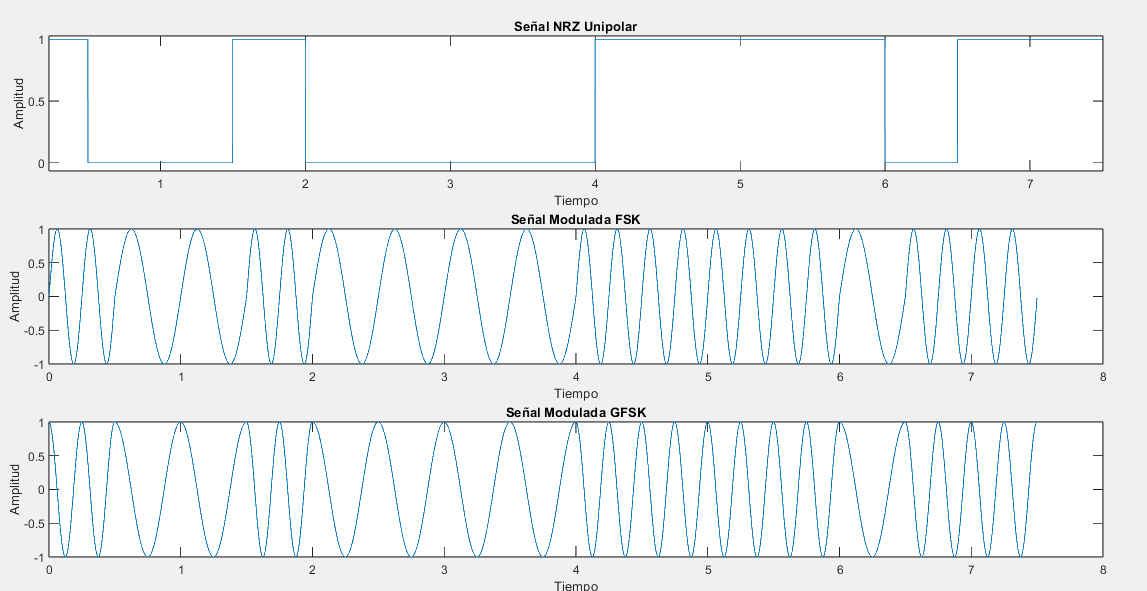

## Bloque antena

#Requerimiento del canal

Este bloque tiene como función principal modelar de una manera aproximada el canal de comunicación entre el transmisor y el receptor, esto se debe a que no se cuenta con un modelo preestablecido del canal.


##Bloque del canal

### Analisis del código de modelado de un canal AWGN

El codigo en C del enlace proporcionado implementa una función en C para generar muestras de ruido blanco gaussiano aditivo utilizando el método de transformación inversa de la distribución normal estándar. Utiliza la función rand() para generar números aleatorios y la función cos() para calcular valores coseno.

Para el codigo en C proporcionado este de igual forma genera ruido blanco gaussiano (AWGN) pero en este caso usando la transformación box-muller, además, muestra la frecuencia de ocurrencia del ruido en diferentes intervalos y provee un archivo para ser representado graficamente.

### Transformada Box-Muller

La transformada Box-Muller es un procedimiento utilizado para obtener pares de números aleatorios independientes que siguen una distribución normal estándar (media cero y varianza uno), utilizando como entrada una fuente de números aleatorios distribuidos. Este método, desarrollado por George Edward Pelham Box y Mervin Edgar Muller, permite generar muestras de una distribución normal a partir de muestras uniformemente distribuidas en un intervalo específico.

A continuación, se procede a mostrar el codigo de modelado del canal con ruido AWGN:

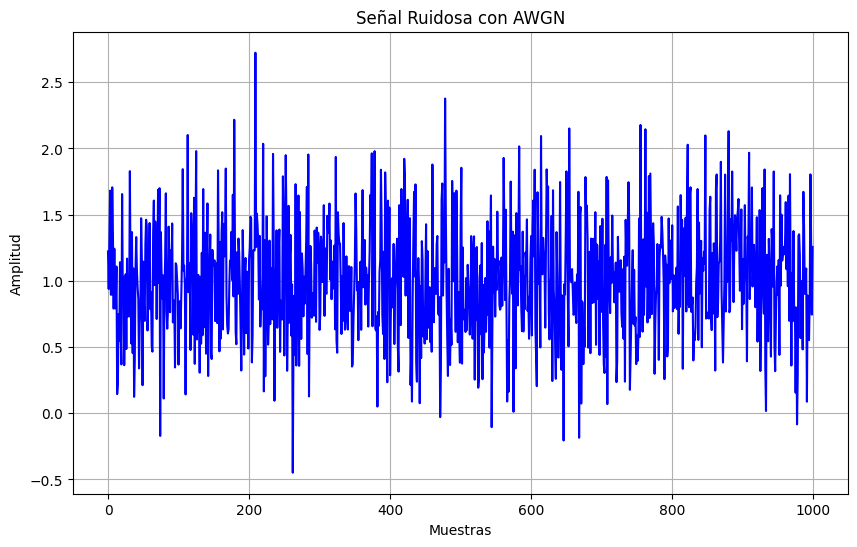

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def awgn_channel(signal_power, noise_power, num_samples):
    # Genera la señal ruidosa utilizando el método de Box-Muller
    noise_std = np.sqrt(noise_power)
    noise = noise_std * np.random.randn(num_samples)
    noisy_signal = signal_power + noise
    return noisy_signal

def main():
    # Parámetros del canal
    signal_power = 1.0  # Potencia de la señal
    noise_power = 0.2  # Potencia del ruido
    num_samples = 1000  # Número de muestras

    # Configuración de la semilla para reproducibilidad
    np.random.seed(42)

    # Genera la señal ruidosa utilizando el canal AWGN
    noisy_signal = awgn_channel(signal_power, noise_power, num_samples)

    # Grafica la señal ruidosa
    plt.figure(figsize=(10, 6))
    plt.plot(noisy_signal, color='blue')
    plt.title('Señal Ruidosa con AWGN')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()



### Fading en señales de comunicación y afectacion en tecnologia BLE.

El fading en señales de comunicación se refiere a la atenuación o variación aleatoria de la amplitud, fase o tiempo de la señal en el momento que se esta propagando sobre el tiempo y la distancia, esto es causa de las condiciones atmosféricas y de propagacion, asi como obstaculos en el entorno de transmisión.

Bluetooth Low Energy (BLE) es una tecnologia que se basa en la transmision de datos de forma inalambrica, por lo que si se trata de una aplicacion medica, el funcionamiento del dicha tecnologia debe ser muy buena, sin embargo, como el mundo no es ideal existiran varios factores que pueden bajar el rendimiento de la transmision de datos lo que provocaria degradacion de la señal, mas probabilidad de errores en la transmision, disminucion del alcance.


### Efecto multicamino en la tecnologia BLE.



# Requerimiento para el módulo Receptor (RX)

## Bloque demodulador

## Bloque decodificador

## Bloque visualización